In [1]:
import sys
from pathlib import Path

lib_path: str = (Path.cwd().parents[1] / "lib").as_posix()
if lib_path not in sys.path:
    sys.path.insert(1, lib_path)

In [2]:
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from Evaluator import Evaluator
from pathlib import Path

In [3]:
class AttributeDict(dict):
    def __getattr__(self, attr):
        return self[attr]

    def __setattr__(self, attr, value):
        self[attr] = value

# Usage
ROOT_DIR = Path.cwd().parent / "data" / "owl2vec"
FLAGS = AttributeDict()
FLAGS['train_file'] = ROOT_DIR / "train.csv"
FLAGS['valid_file'] = ROOT_DIR / "valid.csv"
FLAGS['test_file'] = ROOT_DIR / "test.csv"
FLAGS['class_file'] = ROOT_DIR / "classes.txt"
FLAGS['individual_file'] = ROOT_DIR / "individuals.txt"
FLAGS['inferred_class_file'] = ROOT_DIR / "inferred_classes.txt"
FLAGS["input_type"] ="concatenate"

individuals = [line.strip() for line in open(FLAGS.individual_file).readlines()]
classes = [line.strip() for line in open(FLAGS.class_file).readlines()]
classes_dict = {cls: i for i, cls in enumerate(classes)}
individuals_dict = {cls: i for i, cls in enumerate(individuals)}
candidate_num = len(classes)
ind_infer_classes = dict()
with open(FLAGS.inferred_class_file) as f:
    for line in f.readlines():
        tmp = line.strip().split(',')
        ind = tmp[0]
        ind_infer_classes[ind] = tmp[1:]


In [4]:
TRAIN_PATH = Path.cwd().parent / 'data' / 'Helis' /'train_dataset.tsv'
# MODEL_PATH = Path.cwd() / 'save_owl2vec_weights' / 'owl2vec3.pkl'
MODEL_PATH = Path.cwd() / 'save_pykeen_weights' / 'transF_pykeen_weights.pkl'
CACHEPATH = Path.cwd() / "cache" / (MODEL_PATH.stem + "_cache.pkl")

# Save and Load

In [5]:
owl2vec = MODEL_PATH.parent.name == "save_owl2vec_weights"
if owl2vec:
    with open(MODEL_PATH, 'rb') as f:
        info = pickle.load(f)
        individuals_e = np.array(info["individuals_e"])
        classes_e = np.array(info["classes_e"])
        model_config = info["model_config"]
        
    # classes_e = pd.read_csv(CLASS_MODEL_PATH, header=None).to_numpy()
    # individuals_e = pd.read_csv(IND_MODEL_PATH, header=None).to_numpy()
else:
    with open(MODEL_PATH, 'rb') as f:
        info = pickle.load(f)
    entities_to_id = info["entities_to_id"]
    embedded_vectors = info["embedded_vectors"]
    model_config = info["config"]

    
    classes_e = list()
    for e_class in classes:
        cid = entities_to_id[e_class]
        classes_e.append(embedded_vectors[cid])
    classes_e = np.array(classes_e)

    individuals_e = list()
    missing_individual_e = np.mean(embedded_vectors, axis=0)
    for i,ind in enumerate(individuals):
        if ind in entities_to_id:
            iid = entities_to_id[ind]
            individuals_e.append(np.array(embedded_vectors[iid]))
        else:
            print(f"Missing individual {ind}")
            individuals_e.append(missing_individual_e)
    individuals_e = np.array(individuals_e)
    del embedded_vectors, entities_to_id

individuals_classes_dict = {cls: i for i, cls in enumerate(individuals + classes)}
individuals_classes_e = np.concatenate([individuals_e,classes_e], axis=0)
new_embedsize = classes_e[0].shape[0]
triples = pd.read_csv(TRAIN_PATH, header=None, names=['head', 'relation', 'tail'])

Missing individual http://www.fbk.eu/ontologies/virtualcoach#MR-Piramide-23-GDAY
Missing individual http://www.fbk.eu/ontologies/virtualcoach#MR-Piramide-07-GDAY
Missing individual http://www.fbk.eu/ontologies/virtualcoach#MR-Piramide-05-NDAY
Missing individual http://www.fbk.eu/ontologies/virtualcoach#MR-Piramide-22-QB
Missing individual http://www.fbk.eu/ontologies/virtualcoach#MR-Piramide-29-QB
Missing individual http://www.fbk.eu/ontologies/virtualcoach#MR-Piramide-05-GDAY
Missing individual http://www.fbk.eu/ontologies/virtualcoach#MR-Piramide-07-NWEEK
Missing individual http://www.fbk.eu/ontologies/virtualcoach#MR-Piramide-33-NDAY
Missing individual http://www.fbk.eu/ontologies/virtualcoach#MR-Piramide-12-NWEEK
Missing individual http://www.fbk.eu/ontologies/virtualcoach#MR-Piramide-24-GDAY
Missing individual http://www.fbk.eu/ontologies/virtualcoach#MR-Piramide-20-GDAY
Missing individual http://www.fbk.eu/ontologies/virtualcoach#MR-Piramide-21-QB
Missing individual http://www.fb

In [6]:

print("\n		2.Train and test ... \n")
train_samples = [line.strip().split(',') for line in open(FLAGS.train_file).readlines()]
valid_samples = [line.strip().split(',') for line in open(FLAGS.valid_file).readlines()]
test_samples = [line.strip().split(',') for line in open(FLAGS.test_file).readlines()]
random.shuffle(train_samples)


		2.Train and test ... 



In [7]:

train_x_list, train_y_list = list(), list()
for s in tqdm(train_samples):
    ind, cls, label = s[0], s[1], s[2]
    ind_v = individuals_e[individuals_dict[ind]]
    cls_v = classes_e[classes_dict[cls]]
    if not (np.all(ind_v == 0) or np.all(cls_v == 0)):
        if FLAGS.input_type == 'concatenate':
            train_x_list.append(np.concatenate((ind_v, cls_v)))
        else:
            train_x_list.append(ind_v - cls_v)
        train_y_list.append(int(label))
train_X, train_y = np.array(train_x_list), np.array(train_y_list)
print('train_X: %s, train_y: %s' % (str(train_X.shape), str(train_y.shape)))

100%|██████████| 28444/28444 [00:00<00:00, 41721.90it/s]

train_X: (28444, 200), train_y: (28444,)


In [8]:
class CacheEvaluator():
    def __init__(self, 
                 CACHEPATH = CACHEPATH
    ):
        self.CACHEPATH = CACHEPATH
        self.load_cache()
    
    def load_cache(self):
        if Path(self.CACHEPATH).exists():
            with open(self.CACHEPATH, 'rb') as f:
                self.cache = pickle.load(f)
        else:
            print(f"Cache file {self.CACHEPATH} not found initializing cache to empty dict")
            self.cache = dict()
    
    def save_cache(self):
        with open(self.CACHEPATH, 'wb') as f:
            pickle.dump(self.cache, f)
            
    def add_to_cache(self, key, value):
        self.cache[key] = value
    
    def get_from_cache(self, key):
        return self.cache.get(key, None)
    
    def evaluate(self, eva_samples, ontology_eva_samples):
        inclusion_metrics = self.inclusion_evaluate(eva_samples)
        ontology_metrics = self.ontology_evaluate(ontology_eva_samples)
        return inclusion_metrics, ontology_metrics
    
    def inclusion_evaluate(self, eva_samples):
        
        MR_sum, MRR_sum, hits1_sum, hits5_sum, hits10_sum = 0, 0, 0, 0, 0
        tqdm_data = tqdm(eva_samples)
        for num, (individual, gt) in enumerate(tqdm_data, start = 1):
            sorted_indexes = self.get_from_cache(individual)
            sorted_classes = list()
            for j in sorted_indexes:
                if classes[j] not in ind_infer_classes[individual]:
                    sorted_classes.append(classes[j])
            rank = sorted_classes.index(gt) + 1
            MR_sum += rank
            MRR_sum += 1.0 / rank
            hits1_sum += 1 if gt in sorted_classes[:1] else 0
            hits5_sum += 1 if gt in sorted_classes[:5] else 0
            hits10_sum += 1 if gt in sorted_classes[:10] else 0
            
            e_MR, e_MRR, hits1, hits5, hits10 = MR_sum/num, MRR_sum/num, hits1_sum/num, hits5_sum/num, hits10_sum/num
            tqdm_data.set_description('MR: %.4f, MRR: %.4f, Hits@1: %.4f, Hits@5: %.4f, Hits@10: %.4f' %
                      (e_MR, e_MRR, hits1, hits5, hits10))
        
        return dict(
            MR = e_MR,
            MRR = e_MRR, 
            hits1 = hits1,
            hits5 = hits5, 
            hits10 = hits10,
        )
    
    def ontology_evaluate(self, ontology_eva_samples):
        tracking_semrr = tracking_semr = 0
        tqdm_data = tqdm(ontology_eva_samples)
        for num, data in enumerate(tqdm_data, start = 1):
            sorted_indexes = self.get_from_cache(data[0])
            proposed_sequence = [classes[j] for j in sorted_indexes]
            
            semmr = SemMR(proposed_sequence, data[1:])
            semmrr = SemMRR(proposed_sequence, data[1:])
            
            tracking_semrr += semmrr
            tracking_semr += semmr
            semr, semrr = tracking_semr/num, tracking_semrr/num
            tqdm_data.set_description(f"SemMR: {semr:.4f}, SemMRR: {semrr:.4f}")
            
        return dict(
            SemMR = semr,
            SemMRR = semrr,
        )

In [9]:
class InclusionEvaluator(Evaluator):
    def __init__(self, valid_samples, test_samples, train_X, train_y):
        super(InclusionEvaluator, self).__init__(valid_samples, test_samples, train_X, train_y)

    def evaluate(self, model, eva_samples):
        print('Evaluating...')
        X_array = np.empty((len(eva_samples), candidate_num, train_X.shape[1]), dtype=np.float32)
        for index, (individual, gt) in enumerate(eva_samples):
            individual_index = individuals_dict[individual]
            individual_v = individuals_e[individual_index]
            if FLAGS.input_type == 'concatenate':
                X_array[index] = np.concatenate((np.array([individual_v] * candidate_num), classes_e), axis=1)
            else:
                X_array[index] = np.array([individual_v] * candidate_num) - classes_e
            
        predicted_proba_array = X_array.reshape(-1, train_X.shape[1])
        predicted_proba_array = model.predict_proba(predicted_proba_array)[:, 1].reshape((len(eva_samples), candidate_num))
        
        MR_sum, MRR_sum, hits1_sum, hits5_sum, hits10_sum = 0, 0, 0, 0, 0
        tqdm_data = tqdm(range(len(eva_samples)), desc='MRR: 0.0000, Hits@1: 0.0000, Hits@5: 0.0000, Hits@10: 0.0000')
        for i in tqdm_data:
            P, (individual, gt) = predicted_proba_array[i], eva_samples[i]
            sorted_indexes = np.argsort(P)[::-1]
            cache.add_to_cache(individual, sorted_indexes)

            sorted_classes = list()
            for j in sorted_indexes:
                if classes[j] not in ind_infer_classes[individual]:
                    sorted_classes.append(classes[j])

            rank = sorted_classes.index(gt) + 1
            MR_sum += rank
            MRR_sum += 1.0 / rank
            hits1_sum += 1 if gt in sorted_classes[:1] else 0
            hits5_sum += 1 if gt in sorted_classes[:5] else 0
            hits10_sum += 1 if gt in sorted_classes[:10] else 0
            num = i + 1
            e_MR, e_MRR, hits1, hits5, hits10 = MR_sum / num,MRR_sum / num, hits1_sum / num, hits5_sum / num, hits10_sum / num
            tqdm_data.set_description('MR: %.4f MRR: %.4f, Hits@1: %.4f, Hits@5: %.4f, Hits@10: %.4f' %
                      (e_MR, e_MRR, hits1, hits5, hits10))

        return dict(
            MRR = e_MRR, 
            hits1 = hits1,
            hits5 = hits5, 
            hits10 = hits10,
        )

In [10]:
cache = CacheEvaluator()

Cache file d:\.VScode\projects\Owls2Vec_star\ontology_evaluator\helis\workpace\cache\transF_pykeen_weights_cache.pkl not found initializing cache to empty dict


In [11]:
print("\n		2.Train and test ... \n")
evaluator = InclusionEvaluator(None, None, train_X, train_y)
evaluator.run_random_forest()


		2.Train and test ... 



In [12]:
inclusive_res = evaluator.evaluate(evaluator.best_model, test_samples)

Evaluating...


MR: 34.8462 MRR: 0.1454, Hits@1: 0.0654, Hits@5: 0.1742, Hits@10: 0.2669: 100%|██████████| 4065/4065 [00:04<00:00, 871.68it/s] 


In [13]:
cache.save_cache()

# Concept2Vec

In [14]:
from concept2vec import run_concept2vec_evaluation

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

train_samples_df = pd.DataFrame(train_samples, columns=['individual', 'class', 'label'])
sample_tsne_classes = list(train_samples_df[train_samples_df['label'] == '1']["class"].value_counts().head(10).index)

http://www.fbk.eu/ontologies/virtualcoach#RecipeFood              1002
http://www.fbk.eu/ontologies/virtualcoach#Recipe                   804
http://www.fbk.eu/ontologies/virtualcoach#MonounsaturatedLipid     322
http://www.fbk.eu/ontologies/virtualcoach#SaturatedLipid           321
http://www.fbk.eu/ontologies/virtualcoach#OleicAcid                303
http://www.w3.org/2002/07/owl#Class                                277
http://www.fbk.eu/ontologies/virtualcoach#Lysine                   268
http://www.fbk.eu/ontologies/virtualcoach#AsparticAcid             259
http://www.fbk.eu/ontologies/virtualcoach#Potassium                257
http://www.fbk.eu/ontologies/virtualcoach#GlutamicAcid             256
http://www.fbk.eu/ontologies/virtualcoach#Leucine                  253
http://www.fbk.eu/ontologies/virtualcoach#Valine                   249
http://www.fbk.eu/ontologies/virtualcoach#Isoleucine               248
http://www.fbk.eu/ontologies/virtualcoach#Carbs                    244
http:/

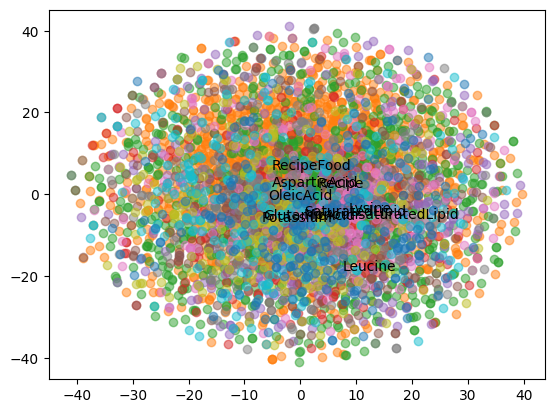

<Figure size 640x480 with 0 Axes>

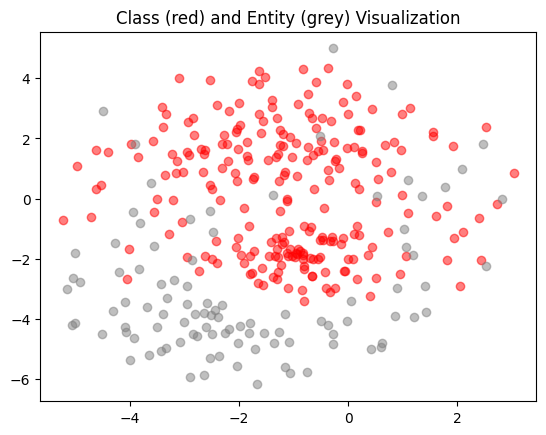

In [15]:
concept_res = run_concept2vec_evaluation(
    triples = triples.values,
    entity_to_id = individuals_classes_dict, 
    embedded_vectors = individuals_classes_e,
    coherence_top_k = 10,
    train_samples = train_samples,
    tsne_classes = sample_tsne_classes
)

# neg-pos distance

In [16]:
from eval_util import run_distance

distance_res = run_distance(
    train_samples = train_samples, 
    embedded_vectors = individuals_classes_e, 
    entity_to_id = individuals_classes_dict
)

Distance in the embedding space of training samples


100%|██████████| 28444/28444 [00:00<00:00, 39750.08it/s]

average_distance:
positive: 5.646
negative: 6.441
ratio 0.877


# Semantic-aligned Evaluation 

In [17]:
from semantic_eval import SemMR, SemMRR
SEM_DATA_PATH = Path.cwd().parent / 'data' / 'semantic' / 'helis_filtered_subsumption_dataset.pkl'
with open(SEM_DATA_PATH, "rb") as f:
    testable_dataset = pickle.load(f)

In [18]:
class ontologyEvaluator(Evaluator):
    def __init__(self, valid_samples, test_samples, train_X, train_y):
        super(ontologyEvaluator, self).__init__(valid_samples, test_samples, train_X, train_y)

    def evaluate(self, model, eva_samples):
        tracking_semrr = tracking_semr = 0
        tqdm_data = tqdm(eva_samples)
        for ind, data in enumerate(tqdm_data, start = 1):
            sub = data[0]
            sub_index = classes_dict[sub]
            sub_v = classes_e[sub_index]
            if FLAGS.input_type == 'concatenate':
                X = np.concatenate((np.array([sub_v] * candidate_num), classes_e), axis=1)
            else:
                X = np.array([sub_v] * candidate_num) - classes_e
            P = model.predict_proba(X)[:, 1]
            sorted_indexes = np.argsort(P)[::-1]
            cache.add_to_cache(sub, sorted_indexes)
            proposed_sequence = [classes[j] for j in sorted_indexes]
            
            semmr = SemMR(proposed_sequence, data[1:])
            semmrr = SemMRR(proposed_sequence, data[1:])
            
            tracking_semrr += semmrr
            tracking_semr += semmr
            tqdm_data.set_description(f"SemMR: {tracking_semr/ind:.4f}, SemMRR: {tracking_semrr/ind:.4f}")
            
        eva_n = len(eva_samples)
        return {
            "SeMR": tracking_semr / eva_n, 
            "SeMRR": tracking_semrr / eva_n
            }

In [19]:
print("\n		2.Train and test ... \n")
ontology_evaluator = ontologyEvaluator(None, None, None, None)
ontology_res = ontology_evaluator.evaluate(evaluator.best_model, testable_dataset)


		2.Train and test ... 



SemMR: 5025.6949, SemMRR: 0.1313: 100%|██████████| 59/59 [00:01<00:00, 37.19it/s]


In [20]:
cache.save_cache()

In [21]:
inclusive_res, ontology_res = cache.evaluate(test_samples, testable_dataset)

MR: 34.8462, MRR: 0.1454, Hits@1: 0.0654, Hits@5: 0.1742, Hits@10: 0.2669: 100%|██████████| 4065/4065 [00:03<00:00, 1025.70it/s]
SemMR: 5025.6949, SemMRR: 0.1313: 100%|██████████| 59/59 [00:00<00:00, 1241.55it/s]


# save result

In [22]:
from eval_util import Report 
report_man = Report()
all_res = dict(
    inclusive = {**inclusive_res, **ontology_res},
    concept = concept_res,
    distance = distance_res,
)
report_man.save(
    name = MODEL_PATH.stem,
    config = dict(
        eval_config = dict(FLAGS),
        model_config =  model_config
    ),
    res = all_res)
report = report_man.load()

Save file successfully
